In [1]:
from joblib import load, dump
import numpy as np
import h5py
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances, distance_metrics
from matplotlib import pyplot as plt
import numba
from umda import DaskMRS, EmbeddingModel
from dask.distributed import Client

plt.style.use('publication')

Traceback (most recent call last):
  File "/home/kelvin/anaconda3/envs/rdkit/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


In [2]:
client = Client(threads_per_worker=2, n_workers=4)

In [3]:
client

Client Scheduler: tcp://127.0.0.1:45717 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.29 GB


In [4]:
embedder = EmbeddingModel.from_pkl("../../models/mol2vec_model.pkl", "../../models/embedding_pipeline.pkl", radius=1)

In [3]:
embedder.save("../../models/EmbeddingModel.pkl")

2020-12-07 17:04:20.465 | INFO     | umda.classes:save:59 - Saved model to ../../models/EmbeddingModel.pkl.


In [4]:
gp_grid = load("../../models/gp_grid.pkl")

dump(gp_grid.best_estimator_, "../../models/best_gp_estimator.pkl")

['../../models/best_gp_estimator.pkl']

In [5]:
mrs_gp = DaskMRS.from_pickle("../../models/kmeans_model.pkl", "../../models/best_gp_estimator.pkl")

mrs_gp.save("../../models/TMC1_MRS_GP.pkl")

2021-02-24 16:30:13.878 | WARNING  | umda.classes:__init__:250 - Dask version of MRS is being run; logging messages may not be accurate!
2021-02-24 16:30:15.810 | INFO     | umda.classes:save:228 - Saved MRS to ../../models/TMC1_MRS_GP.pkl


In [6]:
data = h5py.File("../../data/processed/smiles_embeddings_300.h5", "r")

In [7]:
pipeline = load("../../models/embedding_pipeline.pkl")

In [8]:
tmc1_df = pd.read_pickle("../../data/interim/tmc1_table_vecs.pkl")

In [9]:
tmc1_vecs = np.vstack(tmc1_df["Vecs"])
tmc1_embedding = pipeline[0].transform(tmc1_vecs).compute()

### GP recommendations without clustering 

In [10]:
gp_nocluster_df = mrs_gp.recommend(X=tmc1_embedding, cluster=False, h5_data=data)

2021-02-24 16:30:32.674 | INFO     | umda.classes:recommend:322 - Not using clusters.
2021-02-24 16:30:32.689 | INFO     | umda.classes:recommend:340 - There are nan molecules in this aggregate.


In [26]:
from periodictable import elements

In [43]:
exclude_list = [
    "P", "Ho", "As", "Zr", "Sn", "V", "Au", "Br", "F", "Re", "U", "Al", "In", "Cl", "Ag", "Ce", "Hg", "Ta", "Te", "Ni", "Be", "Li", "Sb", "Bi", "Mn", "Co", "Tm", "Si"
]

In [44]:
gp_recommendations = gp_nocluster_df.loc[(gp_nocluster_df["Abundance"].between(8., 20.)) & (~gp_nocluster_df["SMILES"].str.contains('|'.join(exclude_list),regex=True))].head(50)

In [45]:
gp_recommendations

,Abundance,Uncertainty,Index,SMILES,Counts
8,13.269550,1.833104,71272,S=[S+],8
9,13.208389,1.817918,74122,[C+]#C,26
17,12.851073,1.834660,42075,CC#[S+],30
18,12.838302,1.847769,14546,O=[O+],9
34,12.311587,1.862161,2847,[C+]#CC#[C-],13
36,12.209261,1.866075,25611,N=CO,3
37,12.198914,1.838046,67603,C=C=[C+]C,25
39,12.120914,1.855056,74764,N#CSN,7
43,11.904348,1.860113,57705,N#CC#CC=O,18
44,11.782551,1.873986,22953,N#CC1CN1,3


In [46]:
gp_recommendations.to_csv("gp_recommendations_nocluster_filtered.csv", index=False)

In [47]:
gp_cluster_df = mrs_gp.recommend(X=tmc1_embedding, cluster=True, h5_data=data)

2021-02-25 13:06:56.903 | INFO     | umda.classes:recommend:331 - Using the following clusters: dask.array<getitem, shape=(nan,), dtype=int32, chunksize=(nan,), chunktype=numpy.ndarray>
2021-02-25 13:06:56.914 | INFO     | umda.classes:recommend:340 - There are nan molecules in this aggregate.


In [49]:
gp_cluster_df.sort_values(["Abundance"], ascending=False).head(20)

,Abundance,Uncertainty,Index,SMILES,Counts
0,9.470241,1.940433,18395,C#CC1COC2CC2C1,5
1,8.872396,1.934734,19964,CC1:C:[NH]:C(C=O):N:1,1
2,8.829399,1.911380,416,CC1CC=CC(CO)C1,1
3,8.701645,1.968171,9431,C1OC1C12CC1N1CC12,1
4,8.693258,1.968784,19318,C#CC(O)c1ccncc1,1
5,8.634320,1.948234,27535,N=C1OCC1COC=O,1
6,8.261837,1.945674,26734,O=P(Cl)(Cl)C1C=CC=CC=1,2
7,7.956397,1.944555,359,Cn1cc(Cl)c(CN)n1,2
8,7.930492,1.857817,15497,NCCCC(=O)C(=O)O,17
9,7.771595,1.950596,14433,CC(=O)OCC(Br)CBr,24


In [11]:
comp = gp_cluster_df.sort_values(["Abundance"], ascending=False).head(15)["SMILES"].to_list()

In [12]:
comp

['C#CC1COC2CC2C1',
 'CC1:C:[NH]:C(C=O):N:1',
 'CC1CC=CC(CO)C1',
 'C#CC(O)c1ccncc1',
 'C1OC1C12CC1N1CC12',
 'N=C1OCC1COC=O',
 'O=P(Cl)(Cl)C1C=CC=CC=1',
 'Cn1cc(Cl)c(CN)n1',
 'NCCCC(=O)C(=O)O',
 'CCC1C=C(C)C=CC=1C',
 'CC(=O)OCC(Br)CBr',
 'OC1C2CCC1C1CCCC21',
 'O=S1(=O)CCCC(CO)C1',
 'C1CC1OC1CC2(COC2)C1',
 'C#CCCCn1cc(C)nn1']

## Using gradient boosting for recommendations

In [2]:
boost_grid = load("../../models/gradient_boosting_grid.pkl")

dump(boost_grid.best_estimator_, "../../models/best_gbr_estimator.pkl")

['../../models/best_gbr_estimator.pkl']

In [7]:
mrs_gbr = MRS.from_pickle("../../models/kmeans_model.pkl", "../../models/best_gbr_estimator.pkl")

mrs_gbr.save("../../models/TMC1_MRS_GBR.pkl")

2020-12-08 09:14:02.678 | INFO     | umda.classes:save:224 - Saved MRS to ../../models/TMC1_MRS_GBR.pkl


In [ ]:
gbr_nocluster_df = mrs_gbr.recommend(X=tmc1_embedding, cluster=False, h5_data=data)

2020-12-08 09:17:06.637 | INFO     | umda.classes:recommend:190 - There are 3857598 molecules in this aggregate.


In [8]:
gbr_cluster_df = mrs_gbr.recommend(X=tmc1_embedding, cluster=True, h5_data=data, dist_thres=1e-4)

2020-12-08 09:14:18.471 | INFO     | umda.classes:recommend:181 - Using the following clusters: [ 8  9 13]
2020-12-08 09:14:57.906 | INFO     | umda.classes:recommend:190 - There are 914160 molecules in this aggregate.


In [89]:
gbr_cluster_df.head(50)

NameError: name 'gbr_cluster_df' is not defined

In [154]:
from subprocess import Popen, PIPE
import matplotlib.image as image
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

In [155]:
def add_image(axis, filepath, zoom=0.15, position=[0.0, 0.0]):
    """
        Function to add an image annotation to a specified axis.
        Takes the matplotlib axis and filepath to the image as input,
        and optional arguments for the scaling (zoom) and position of
        the image in axis units.
    """
    image = OffsetImage(plt.imread(filepath, format="png"), zoom=zoom)
    image.image.axes = axis

    box = AnnotationBbox(
        image, position, xybox=position, xycoords="data", frameon=False
    )
    axis.add_artist(box)


In [156]:
for index, smi in enumerate(comp):
    cmd = f"""obabel -:"{smi}" -opng"""
    with open(f"molecules/{index}.png", "w+") as write_file:
        proc = Popen(cmd, stdout=write_file, shell=True)

In [157]:
selected = gbr_cluster_df.loc[gbr_cluster_df["SMILES"].isin(comp[:10])]
gp_selected = gp_cluster_df.loc[gp_cluster_df["SMILES"].isin(comp[:10])]

selected.reset_index(inplace=True, drop=True)

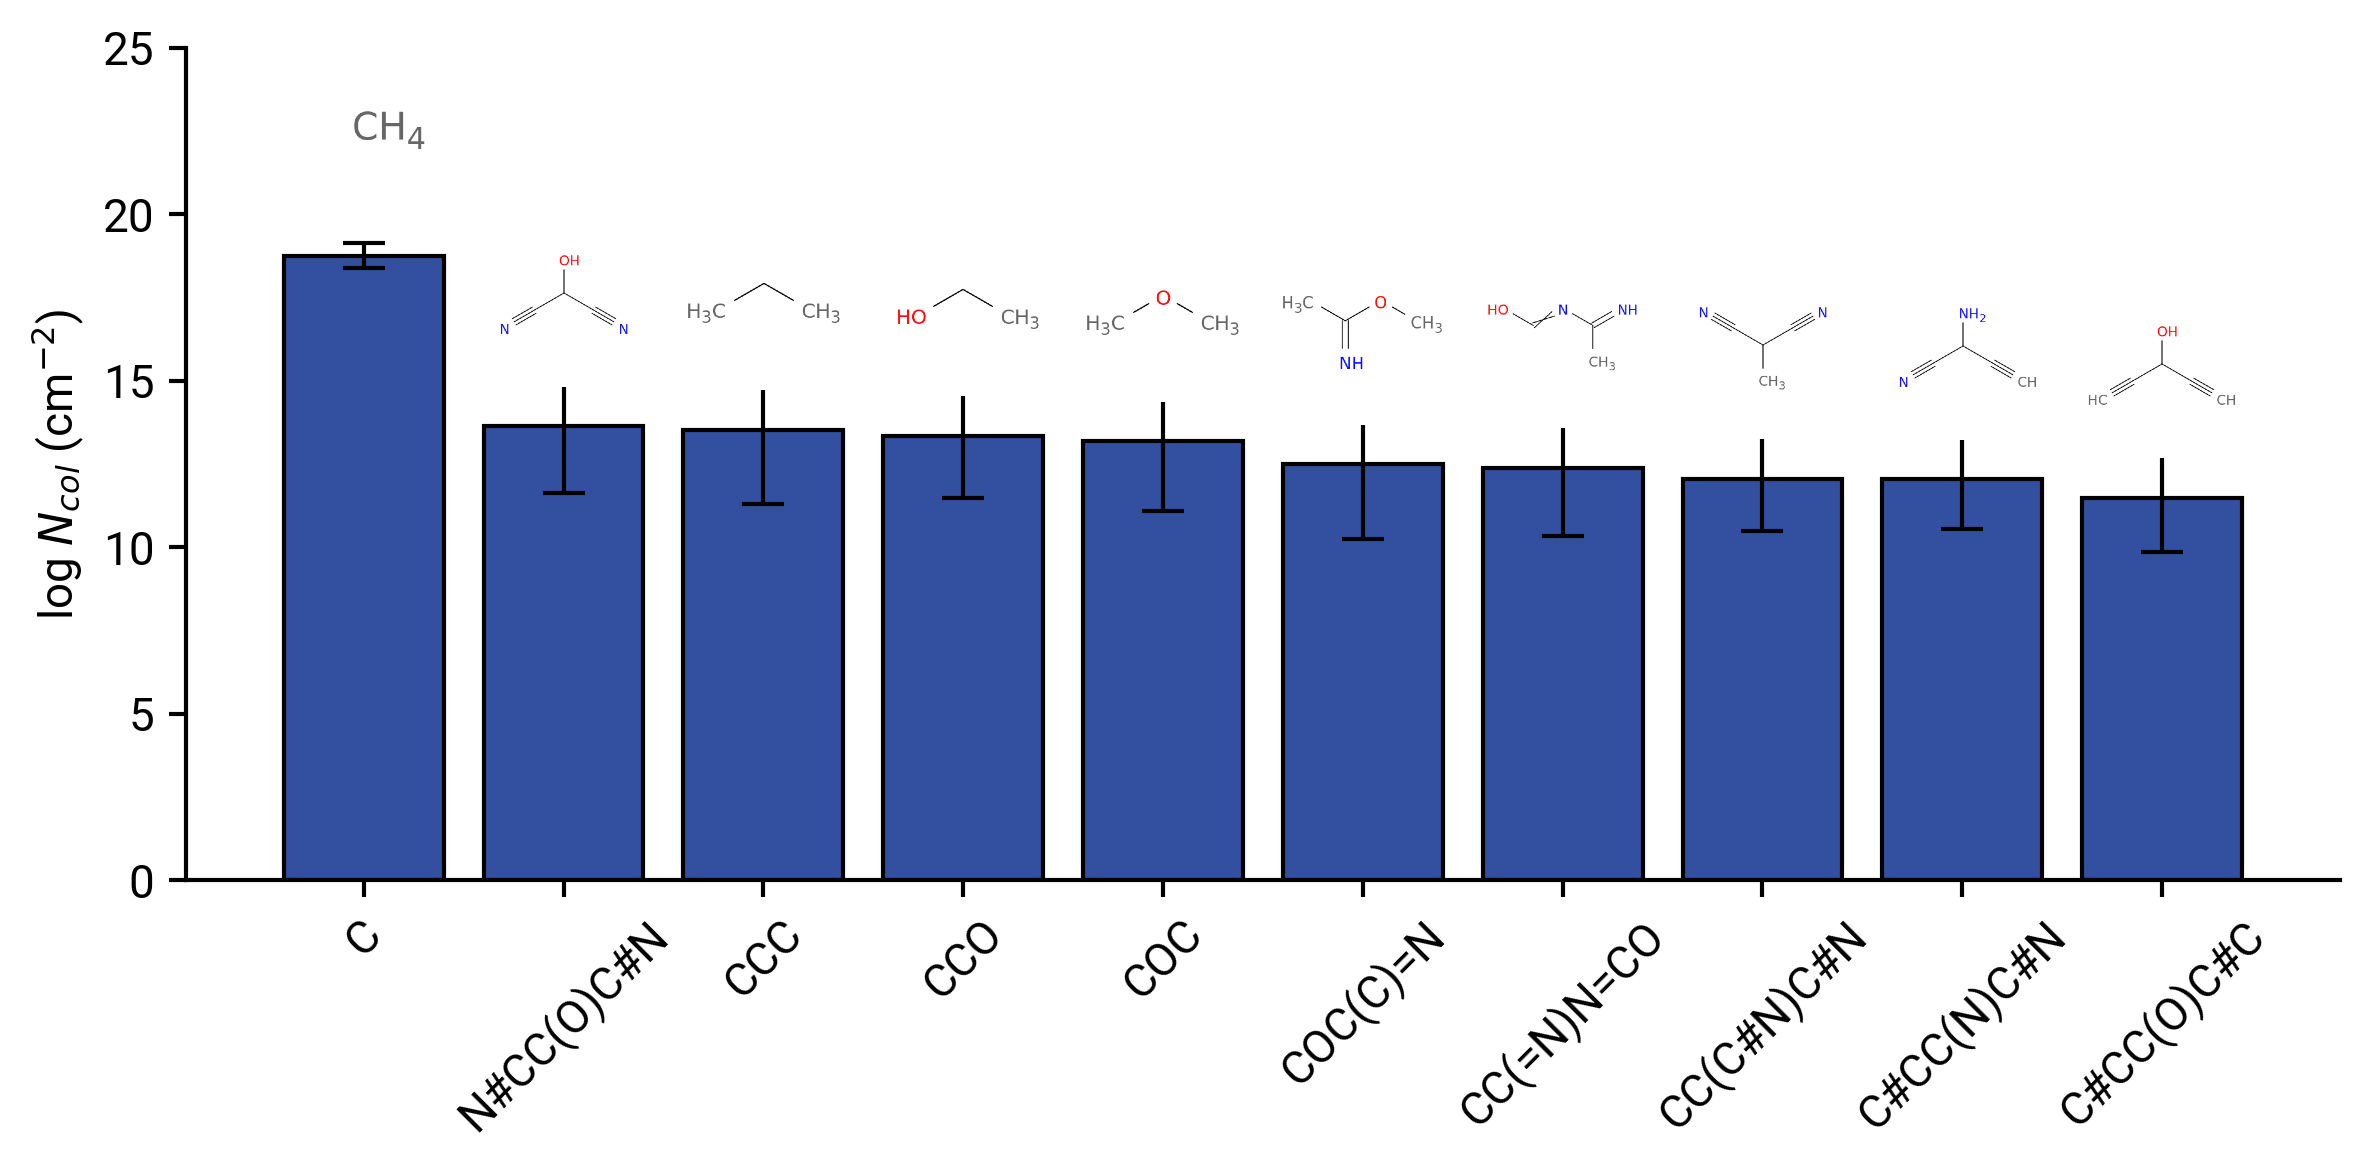

In [158]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(np.arange(len(selected)), selected["Abundance"], yerr=gp_selected["Uncertainty"], capsize=5, linewidth=1., edgecolor="k")
ax.set_xticks(np.arange(len(selected)))
ax.set_xticklabels(comp, rotation=45)
for index, row in selected.iterrows():
    add_image(ax, f"molecules/{index}.png", zoom=0.15, position=[index, row["Abundance"] + 4.])
ax.set_ylim([0., 25.])
ax.set_ylabel("log $N_{col}$ (cm$^{-2}$)")
fig.savefig("example-predictions.png", dpi=300, transparent=True)

## Requests

In [50]:
targets = [
    "C1=CNC=C1",   # pyrrole
    "C1=CC=NC=C1", # pyridine
    "C1=CC=C(C(=C1)C#N)C#N", # ortho-DCB
    "C(C(=O)O)N", # glycine
    "C1C=CC2=CC=CC=C21", # indene
    "C1=CC=CC=C1", # benzene
    "C1=CC=C(C=C1)O", # phenol
    "C1=CC=C2C=C3C=CC=CC3=CC2=C1", # anthracene
    "C1=CC=C2C=CC=CC2=C1", # naphthalene
    "C#N", # hydrogen cyanide
]

In [51]:
target_df = mrs_gp.predict(smi=targets, embedding_model=embedder)

In [52]:
target_df["Name"] = ["Pyrrole", "Pyridine", "ortho-DCB", "Glycine", "Indene", "Benzene", "Phenol", "Anthracene", "Naphthalene", "Hydrogen cyanide"]

In [53]:
target_df

,Abundance,Uncertainty,SMILES,Name
0,11.342027,1.880711,C1=CNC=C1,Pyrrole
1,10.756382,1.889131,C1=CC=NC=C1,Pyridine
2,10.147371,1.924440,C1=CC=C(C(=C1)C#N)C#N,ortho-DCB
3,10.566735,1.848942,C(C(=O)O)N,Glycine
4,9.572698,1.905230,C1C=CC2=CC=CC=C21,Indene
5,11.170639,1.904580,C1=CC=CC=C1,Benzene
6,10.427209,1.888029,C1=CC=C(C=C1)O,Phenol
7,7.024256,2.050570,C1=CC=C2C=C3C=CC=CC3=CC2=C1,Anthracene
8,9.131197,1.962772,C1=CC=C2C=CC=CC2=C1,Naphthalene
9,12.691491,0.517970,C#N,Hydrogen cyanide


In [19]:
indene = np.sum([1345768928638.639, 2727913957371.784, 1753385269270.761, 3079442410060.451])

In [20]:
print(f"{indene:.4e}")

8.9065e+12


In [21]:
tmc1_predict = mrs_gp.predict(X=tmc1_embedding, smi=tmc1_df["SMILES"].to_list())

In [22]:
tmc1_predict["Observed"] = np.log10(tmc1_df["Column density (cm^-2)"].values)

In [24]:
tmc1_predict.iloc[60:73]

,Abundance,Uncertainty,SMILES,Observed
60,12.209865,0.705337,C#CC#C[C+]=O,12.230449
61,11.443057,0.705723,C=N,11.176091
62,13.012256,0.705765,C=O,13.079181
63,11.487834,0.705322,C#CC#[O+],11.322219
64,11.726483,0.705708,O=C=[OH+],11.602060
65,11.679801,0.705798,C=[OH+],11.477121
66,10.892450,0.705462,NC#[O+],10.602060
67,11.103087,0.705668,C#NO,10.845098
68,11.323161,0.705201,N#CO,11.041393
69,20.626199,0.699954,[HH],22.000000


In [25]:
tmc1_predict.sample(20, replace=False)

,Abundance,Uncertainty,SMILES,Observed
42,11.869127,0.716729,C#CC#CC#CC#CC#CC#N,12.017033
24,13.803616,0.518019,C#CC#N,13.550228
4,12.789403,0.705246,N#[NH+],12.698970
50,11.165463,0.706468,C=CC#CC#N,11.071882
11,12.369172,0.706473,C=C=C,12.397940
34,12.663339,0.707321,C#CC#CC#C,12.740363
79,11.202186,0.705875,N#CC#[NH+],10.934498
16,12.949444,0.705550,N=C=O,13.029384
26,11.531823,0.428827,C#CC=O,11.920123
23,13.111632,0.706852,C=C=C=C,13.336460


In [26]:
np.mean(np.square(tmc1_predict["Abundance"] - tmc1_predict["Observed"]))

0.07268617882704474

### Cyanopolyyne comparison

In [27]:
cp_smiles = [
    "C#N",
    "C#CC#N",
    "C#CC#CC#N",
    "C#CC#CC#CC#N",
    "C#CC#CC#CC#CC#N",
    "C#CC#CC#CC#CC#CC#N",
#     "C#CC#CC#CC#CC#CC#CC#N"
]

In [43]:
cp_vectors = np.vstack([embedder.vectorize(smi) for smi in cp_smiles]).compute()

In [28]:
cp_df = mrs_gp.predict(smi=cp_smiles, embedding_model=embedder)

In [37]:
cp_df

,Abundance,Uncertainty,SMILES
0,12.691551,0.517981,C#N
1,13.803616,0.518019,C#CC#N
2,13.604588,0.705803,C#CC#CC#N
3,13.316949,0.707700,C#CC#CC#CC#N
4,13.056312,0.711130,C#CC#CC#CC#CC#N
5,11.869127,0.716729,C#CC#CC#CC#CC#CC#N


In [51]:
names = ["Hydrogen cyanide", "Cyanoacetylene", "Cyanodiacetylene", "Cyanotriacetylene", "Cyanotetraacetylene", "Cyanopentaacetylene"]

In [53]:
cp_comp_df = pd.merge(tmc1_df.loc[tmc1_df["Molecule"].isin(names)], cp_df, on="SMILES")

In [54]:
x = np.arange(1, len(cp_smiles) * 2 + 1., 2)

absent = [0, 2, 4]

In [55]:
mask = np.ones_like(x, dtype=bool)

In [56]:
mask[absent] = False

In [57]:
x[absent]

array([1., 5., 9.])

In [58]:
cp_comp_df = cp_comp_df.iloc[[5, 0, 1, 2, 3, 4]]

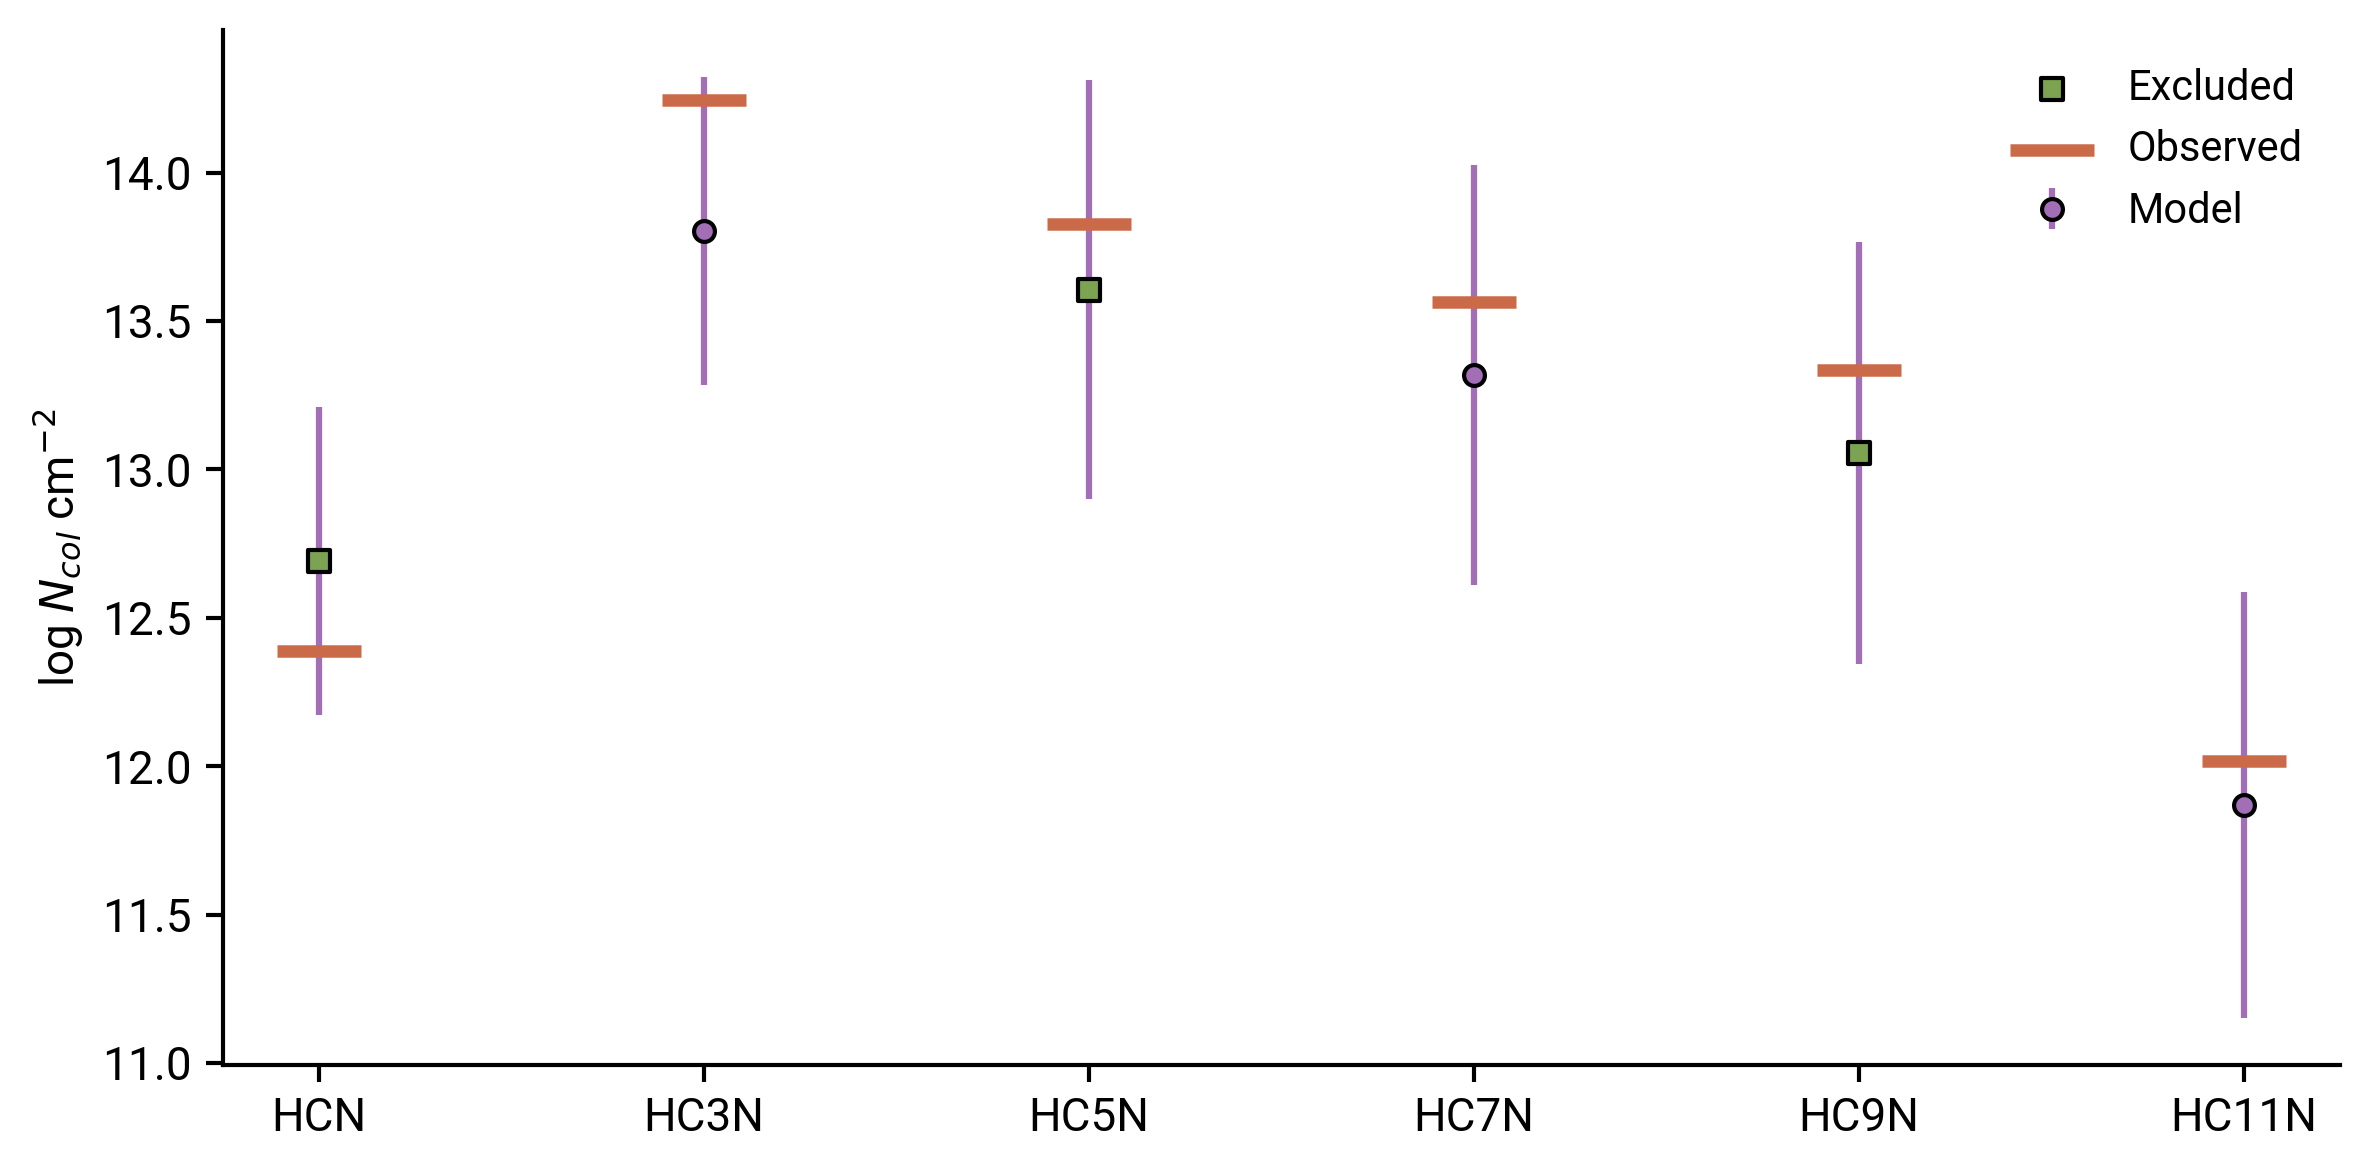

In [88]:
fig, ax = plt.subplots(figsize=(8,4))

ax.errorbar(x, cp_df["Abundance"], yerr=cp_df["Uncertainty"], label="Model", fmt="o", zorder=1, color="#a26fb7", lw=0.5, markeredgecolor="k", elinewidth=1.5)
ax.scatter(x[absent], cp_df["Abundance"].iloc[absent], zorder=2, c="#7ba351", marker="s", label="Excluded",  lw=1., edgecolors="k", s=30.)
ax.scatter(x, np.log10(cp_comp_df["Column density (cm^-2)"]), marker='_', s=400, lw=3., label="Observed", c="#cb6a49")
ax.set_xticks(x)
ax.set_xticklabels(["HCN", "HC3N", "HC5N", "HC7N", "HC9N", "HC11N"])
ax.set_ylabel("log $N_{col}$ cm$^{-2}$")
ax.legend()
fig.savefig("../../reports/figures/cyanopolyyne_validation.png", dpi=300, transparent=True)

In [64]:
cp_df["Abundance"]

0    12.691551
1    13.803616
2    13.604588
3    13.316949
4    13.056312
5    11.869127
Name: Abundance, dtype: float64